In [178]:
# Libraries to help with string preprocessing
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import string

# Libraries for model building
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay, confusion_matrix, f1_score
from sklearn.utils import resample
from sklearn import svm


# Libraries for EDA
from wordcloud import WordCloud
import spacy
from nltk.corpus import wordnet
from textwrap import wrap

import tensorflow as tf

## Amazon Kindle Store Sentiment Analysis

- Data available here: http://jmcauley.ucsd.edu/data/amazon/
- Goal: To train a model that can predict whether a line of text has positive or negative connotations.


In [3]:
import pandas as pd

# Reading in the data
review = pd.read_json(r'C:\Users\De Yuan\Downloads\NUS\Intern\Data Science Projects\NLP\Kindle_Store_5.json', lines=True)

In [4]:
review.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1F6404F1VG29J,B000F83SZQ,Avidreader,"[0, 0]",I enjoy vintage books and movies so I enjoyed ...,5,Nice vintage story,1399248000,"05 5, 2014"
1,AN0N05A9LIJEQ,B000F83SZQ,critters,"[2, 2]",This book is a reissue of an old one; the auth...,4,Different...,1388966400,"01 6, 2014"
2,A795DMNCJILA6,B000F83SZQ,dot,"[2, 2]",This was a fairly interesting read. It had ol...,4,Oldie,1396569600,"04 4, 2014"
3,A1FV0SX13TWVXQ,B000F83SZQ,"Elaine H. Turley ""Montana Songbird""","[1, 1]",I'd never read any of the Amy Brewster mysteri...,5,I really liked it.,1392768000,"02 19, 2014"
4,A3SPTOKDG7WBLN,B000F83SZQ,Father Dowling Fan,"[0, 1]","If you like period pieces - clothing, lingo, y...",4,Period Mystery,1395187200,"03 19, 2014"


In [171]:
review.info()
#no null values, which is good

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982619 entries, 0 to 982618
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      982619 non-null  object
 1   asin            982619 non-null  object
 2   reviewerName    978820 non-null  object
 3   helpful         982619 non-null  object
 4   reviewText      982619 non-null  object
 5   overall         982619 non-null  int64 
 6   summary         982619 non-null  object
 7   unixReviewTime  982619 non-null  int64 
 8   reviewTime      982619 non-null  object
dtypes: int64(2), object(7)
memory usage: 67.5+ MB


In [6]:
# Extracting the 3 important columns
reviews = review[['reviewText', 'overall','summary']]
reviews.head(5)

,reviewText,overall,summary
0,I enjoy vintage books and movies so I enjoyed ...,5,Nice vintage story
1,This book is a reissue of an old one; the auth...,4,Different...
2,This was a fairly interesting read. It had ol...,4,Oldie
3,I'd never read any of the Amy Brewster mysteri...,5,I really liked it.
4,"If you like period pieces - clothing, lingo, y...",4,Period Mystery


# EDA

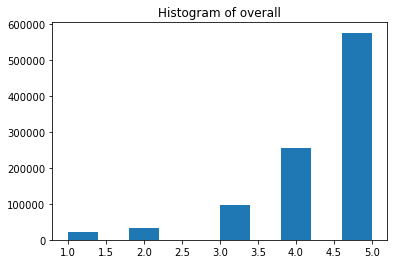

In [7]:
# plotting histogram of the overall column, which is a score of 1-5 for each review (row in the dataset).
def plothistogram(df, column):
    fig = plt.figure
    plt.hist(df[column])
    plt.title('Histogram of ' + column)
    plt.show()


plothistogram(reviews,'overall')

From the Histogram above, the data is skewed towards the ratings of 4 and 5.

In [8]:
stop = stopwords.words("english")
unwanted = re.compile('[^a-z]+')

# function to help clean up stopwords and punctuation,

def cleandata(sentence):
    sentence = str(sentence)
    sentence = sentence.lower() #lowercase all words
    sentence = unwanted.sub(' ',sentence).strip() #remove punctuation
    sentence = sentence.split() #split into individual words
    sentence = [word for word in sentence if word not in stop] #remove common english stopwords
    sentence = ' '.join(word for word in sentence)
    return sentence
    

In [9]:
# Creating a stratified sample, as there are too many data points in the original set.

sample = reviews.groupby('overall').apply(lambda x : x.sample(frac=0.05)).reset_index(drop =True)
sample.head()

,reviewText,overall,summary
0,This is so short with very little info. Just n...,1,Very short
1,Beyond Control was not my favorite book. The w...,1,Very frustrating!
2,I was hoping for a unique storyline beyond the...,1,Kinda Creepy & Unsettling
3,"The plot and characters had great potential, b...",1,Unrealistic chick-lit. Grammatical mistakes t...
4,I hope next book does not continue to drag thi...,1,GOOD BOOK UNTIL LAME ENDING


In [10]:
from sklearn.utils import shuffle

#Shuffling the sample to ensure there is no pattern in the distribution of reviews

sample = shuffle(sample).reset_index(drop=True)
sample= sample[['reviewText','overall','summary']]

print(sample.shape)
sample.head()

(49131, 3)


,reviewText,overall,summary
0,I love this book. Very deep and make me think ...,5,"Marquita Herald, thank you for good book!"
1,"Wow, that was a quick read. I love this storyl...",5,Hot hot hot
2,I really enjoyed this story. There's great ch...,4,Lucky Break
3,Why is it that these great newspapers cannot f...,3,Another Blah digital newspaper
4,Lady Charlotte does not have a lot of control ...,4,Misunderstood leads find love


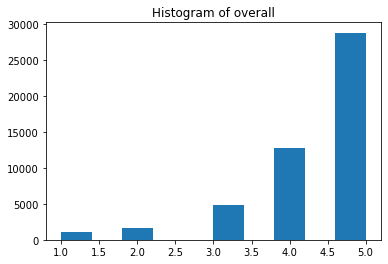

In [11]:
# Histogram of the sample, which has a similar distribution of the dataset
plothistogram(sample,'overall')

In [12]:
sample['reviewText'] = sample['reviewText'].apply(cleandata)
sample['summary'] = sample['summary'].apply(cleandata)

#data after processing
sample.head()

,reviewText,overall,summary
0,love book deep make think hopes find insipatio...,5,marquita herald thank good book
1,wow quick read love storyline way author portr...,5,hot hot hot
2,really enjoyed story great chemistry lucky jar...,4,lucky break
3,great newspapers cannot figure digital format ...,3,another blah digital newspaper
4,lady charlotte lot control life thanks hoverin...,4,misunderstood leads find love


In [13]:
# Group by overall, to see if there are any patterns in the words used in reviews of the same overall.
data = sample.groupby('overall').agg(lambda x: ' '.join(x))
data.head()

,reviewText,summary
overall,,
1,book opens walled compound large group survivo...,christian novel heavy religious overtones poin...
2,love g books one strayed formula bit enjoy muc...,best great story poorly executed overcome star...
3,great newspapers cannot figure digital format ...,another blah digital newspaper fun short story...
4,really enjoyed story great chemistry lucky jar...,lucky break misunderstood leads find love good...
5,love book deep make think hopes find insipatio...,marquita herald thank good book hot hot hot lo...


In [174]:
def wordcloud(data,overall):
  wc = WordCloud(width=600, height=530, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap('Word Cloud for reviews with overall: ' + str(overall),60)),fontsize=13)
  plt.show()

In [15]:
# Initialise countvectorizer to count occurrences of words in each overall.
CV = CountVectorizer(max_features = 10000)

# CV for review text
reviewdata = CV.fit_transform(data['reviewText'])
reviewdata = pd.DataFrame(reviewdata.toarray(), columns = CV.get_feature_names())
reviewdata.index = data['reviewText'].index
reviewdata.head()

# CV for summary text
summarydata = CV.fit_transform(data['summary'])
summarydata = pd.DataFrame(summarydata.toarray(), columns = CV.get_feature_names())
summarydata.index = data['summary'].index
summarydata.head()


,aaaaaaaaaahhhhhhhh,aacute,aaron,abandoned,abbey,abbi,abby,abe,abilities,able,...,zoom,zorn,zowee,zpoc,zsadist,zucchini,zulema,zur,zwei,zzz
overall,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,2,1,0,1,1,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
5,1,1,5,1,1,3,4,2,2,7,...,0,1,1,1,1,1,3,1,1,0


In [16]:
reviewdata = reviewdata.transpose()
summarydata = summarydata.transpose()

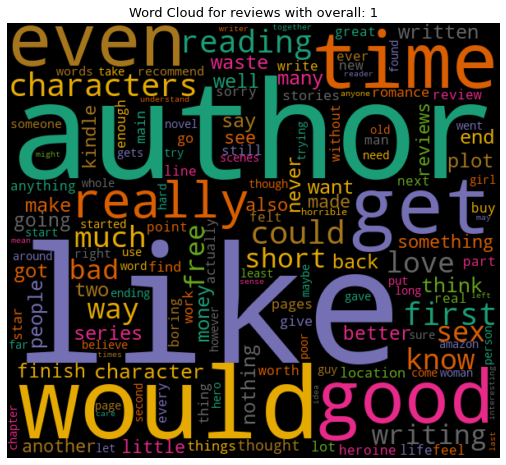

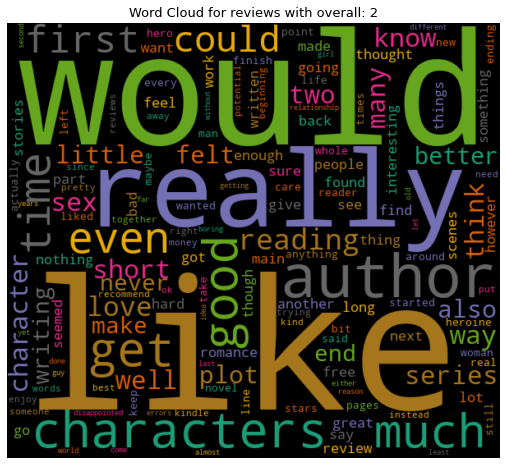

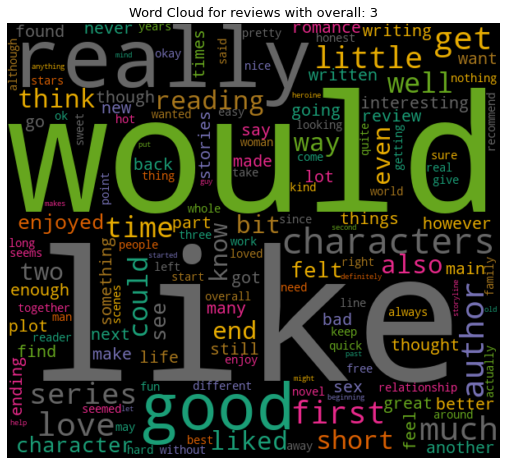

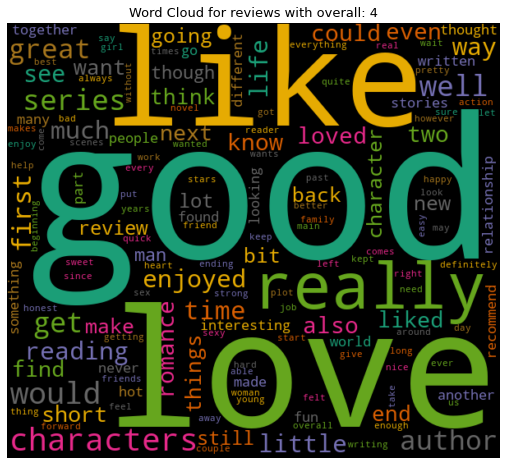

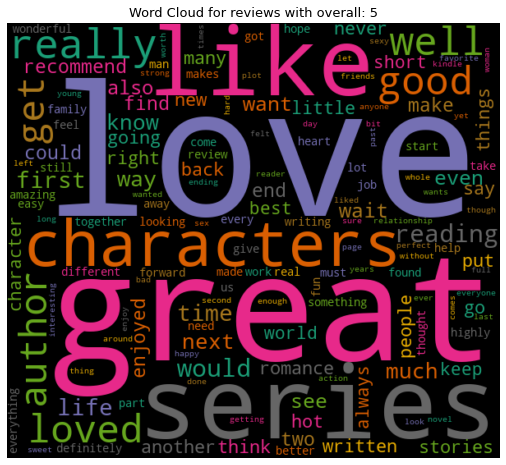

In [175]:
# Plotting the word cloud
for index, col in enumerate(reviewdata.columns):
    wordcloud(reviewdata[col].sort_values(ascending=False),col)


In [18]:
# dropping some common words that have not much help in the sentiment
reviewdata.drop(['book','books','read','story','one'], axis = 0 , inplace=True)

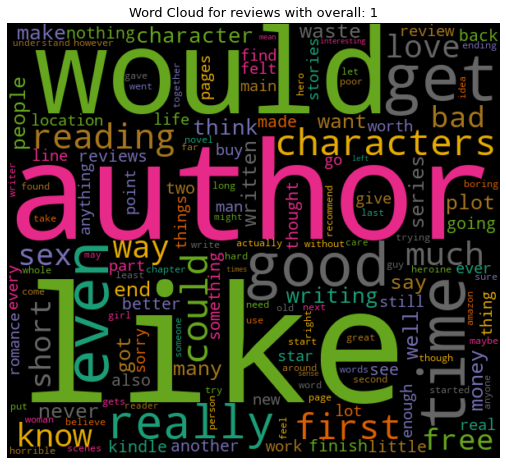

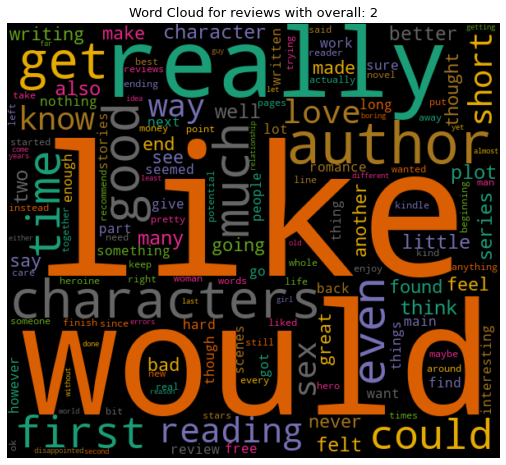

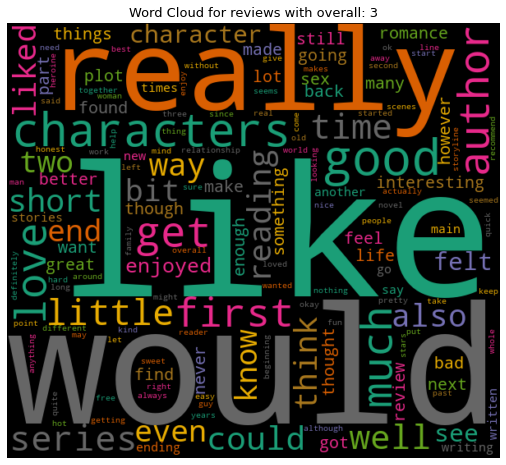

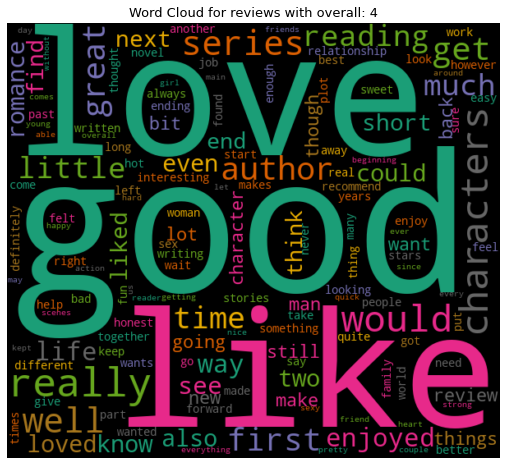

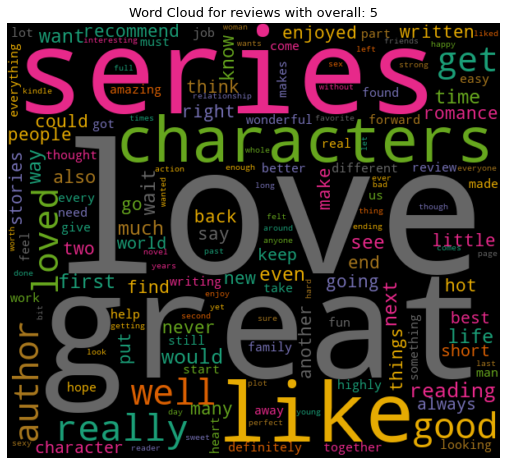

In [176]:


for index, col in enumerate(reviewdata.columns):
    wordcloud(reviewdata[col].sort_values(ascending=False),col)


# Model Building

In [20]:
# To simplify the task, reviews with overall 3 will be dropped,
# which provides a greater distinction between negative and positive reviews

sample = sample.drop(sample[sample.overall == 3].index)
sample.head()


,reviewText,overall,summary
0,love book deep make think hopes find insipatio...,5,marquita herald thank good book
1,wow quick read love storyline way author portr...,5,hot hot hot
2,really enjoyed story great chemistry lucky jar...,4,lucky break
4,lady charlotte lot control life thanks hoverin...,4,misunderstood leads find love
5,read first two books series read one certain e...,4,good read


In [21]:
sample['sentiment'] = np.where(sample['overall']>3,'Positive','Negative')

In [22]:
# Final Distribution of sentiment in the sample. 
# Negative samples are extremely rare, thus data augementation is required.

sample['sentiment'].value_counts()

Positive    41464
Negative     2857
Name: sentiment, dtype: int64

In [23]:
train, test = train_test_split(sample,test_size = 0.2,random_state =1)

In [179]:
train.head()

,reviewText,overall,summary,sentiment
3965,ok must miss something like rest story buy cha...,1,sort like good,Negative
14881,book poems cute funny enjoyed reading rhymes t...,4,funny cute,Positive
16300,book two blood rose tales series long shorts s...,4,subtle yet unrelenting,Positive
46617,written review read ton books amazing book rea...,5,completely heartbroken,Positive
20369,thought book great beginning trilogy thoroughl...,5,really good start really good trilogy,Positive


In [30]:
# Random sampling from positive sentiments, to ensure that training dataset has equal number of positive and negative
# examples.

negative_senti = train[(train['sentiment'] == 'Negative')]
positive_senti = train[train['sentiment'] =='Positive']

print("Negative samples before downsampling:", negative_senti.shape[0])
print("Positive samples before downsampling:", positive_senti.shape[0])

Down_positive = resample(positive_senti, replace = False, n_samples = negative_senti.shape[0], random_state =1)
DS_train = pd.concat([Down_positive, negative_senti]) # Resampled training, with equal negative and positive

print("\nAfter downsampling\n", DS_train['sentiment'].value_counts(), sep = "")

Negative samples before downsampling: 2250
Positive samples before downsampling: 33206

After downsampling
Positive    2250
Negative    2250
Name: sentiment, dtype: int64


In [206]:
DS_train_x = DS_train['reviewText']
DS_train_y = DS_train['sentiment']

# Use TFIDF Vectorizer to help account for contextual meanings of words,
# and weigh their importances throughout the corpus

TV = TfidfVectorizer()
DS_train_x_vect = TV.fit_transform(DS_train_x)
DS_test_x_vect = TV.transform(test_x)

In [34]:
# Fitting a Support Vector Classifier
DS_svm = svm.SVC(kernel='linear')
DS_svm.fit(DS_train_x_vect, DS_train_y)

SVC(kernel='linear')

In [35]:
f1_score(test_y,DS_svm.predict(DS_test_x_vect), average = None, labels = ['Positive','Negative'])

array([0.93291512, 0.5028463 ])

In [117]:
print(classification_report(test_y,DS_svm.predict(DS_test_x_vect)))

              precision    recall  f1-score   support

    Negative       0.35      0.87      0.50       607
    Positive       0.99      0.88      0.93      8258

    accuracy                           0.88      8865
   macro avg       0.67      0.88      0.72      8865
weighted avg       0.95      0.88      0.90      8865



## Deep Learning Model
- With a traditional ML approach done, lets try a Deep Learning approach to this classification problem

In [128]:
NN_train_x = DS_train['reviewText'].tolist()
NN_test_x = test_x.tolist()

In [129]:
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence

# Convert the columns of reviews to word sequences
NN_train_x = [text_to_word_sequence(x) for x in NN_train_x]
NN_test_x = [text_to_word_sequence(x) for x in NN_test_x]

# Tokenize the word sequences, with a maximum vocabulary of 10000
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(NN_train_x)
train_text = tokenizer.texts_to_sequences(NN_train_x)
test_text = tokenizer.texts_to_sequences(NN_test_x)


from tensorflow.keras.preprocessing.sequence import pad_sequences

# Padding to ensure all reviews have the same length, which makes it faster and easier for the NN to train.
pad_length = max(len(sequence) for sequence in train_text)
train_text = pad_sequences(train_text, maxlen = pad_length, padding = 'post')
test_text = pad_sequences(test_text, maxlen = pad_length, padding = 'post')



In [46]:
# Total number of words
vocab_size = len(tokenizer.word_index) +1 

In [157]:
# Define a simple, linear CNN 

def get_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10001,35,input_length = pad_length), 
        # Embedding layer for the NN to learn, with 35 dimensions of output
        tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        # Convolution and Pooling layers 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        #Final Output layer
        tf.keras.layers.Dense(1, activation='sigmoid')])
    
    model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])
    
    return model

In [158]:
# Converting Positive/Negative to Boolean
helper = {'Positive': 0, 'Negative': 1}
NN_train_y = DS_train_y.map(helper)
NN_test_y = test_y.map(helper)

model = get_model()

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 1394, 35)          350035    
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 1387, 32)          8992      
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 693, 32)           0         
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 686, 32)           8224      
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 343, 32)           0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 10976)             0         
_________________________________________________________________
dense_69 (Dense)             (None, 16)              

In [74]:
import random

In [159]:
# For reproducibility
random.seed(1)

# Use of early stopping to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor ='val_loss',patience = 3, min_delta =0.01)
model.fit(
    train_text,np.array(NN_train_y), epochs = 10, 
    validation_data = (test_text,np.array(NN_test_y)),callbacks = [callback])

Epoch 1/10
141/141 [==============================] - 24s 172ms/step - loss: 0.6882 - accuracy: 0.5347 - val_loss: 0.4735 - val_accuracy: 0.8504
Epoch 2/10
141/141 [==============================] - 25s 174ms/step - loss: 0.4948 - accuracy: 0.8016 - val_loss: 0.3010 - val_accuracy: 0.8432
Epoch 3/10
141/141 [==============================] - 25s 180ms/step - loss: 0.2639 - accuracy: 0.8976 - val_loss: 0.2529 - val_accuracy: 0.8805
Epoch 4/10
141/141 [==============================] - 26s 181ms/step - loss: 0.1752 - accuracy: 0.9338 - val_loss: 0.2701 - val_accuracy: 0.9107
Epoch 5/10
141/141 [==============================] - 24s 173ms/step - loss: 0.1134 - accuracy: 0.9571 - val_loss: 0.4703 - val_accuracy: 0.8743
Epoch 6/10
141/141 [==============================] - 24s 174ms/step - loss: 0.0781 - accuracy: 0.9704 - val_loss: 0.4661 - val_accuracy: 0.8908


In [160]:
cm = confusion_matrix(y_true=np.array(NN_test_y), y_pred = np.round(model.predict(test_text)))


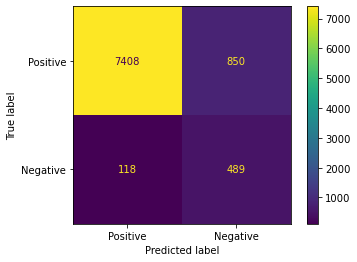

In [161]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Negative'])
disp.plot()

In [162]:
# Deep Learning Model Metrics

print(classification_report(np.array(NN_test_y),np.round(model.predict(test_text))))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      8258
           1       0.37      0.81      0.50       607

    accuracy                           0.89      8865
   macro avg       0.67      0.85      0.72      8865
weighted avg       0.94      0.89      0.91      8865



In [180]:
# SVC Learning Model Metrics

print(classification_report(test_y,DS_svm.predict(DS_test_x_vect)))

              precision    recall  f1-score   support

    Negative       0.35      0.87      0.50       607
    Positive       0.99      0.88      0.93      8258

    accuracy                           0.88      8865
   macro avg       0.67      0.88      0.72      8865
weighted avg       0.95      0.88      0.90      8865



In [208]:
sentence1 = 'This book was very bad.'
sentence2 = 'This book was very good, I loved it!'
sentence3 = 'This book was not good...'

testreviews = [sentence1,sentence2,sentence3]

testwords = [text_to_word_sequence(x) for x in testreviews]

test_sequences = tokenizer.texts_to_sequences(testwords)

test_sequences = pad_sequences(test_sequences, maxlen = pad_length, padding = 'post')

# Sample Predictions with Deep Learning, 0 = Positive, 1 = Negative
predictions = np.round(model.predict(test_sequences))
predictions


array([[1.],
       [0.],
       [1.]], dtype=float32)

In [209]:
cleanedreview = [cleandata(x) for x in testreviews]
transformedreview = TV.transform(testreviews)
SVMpredictions = DS_svm.predict(transformedreview)
SVMpredictions

array(['Negative', 'Positive', 'Positive'], dtype=object)

# Conclusion

- F scores for negative reviews for both models are quite low, due to the low precision. 
- This could be due to the lack of complexity in the model, which does not account for bigrams/lemmatization
- Another improvement could be to use Recurrent Neural Networks, but as a baseline model with simple NNs and SVM, this was a decent result.